# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import *  # imports all functions from definitions.py

xr.set_options(
    keep_attrs=True, display_style="html"
)  # Attributes of DataArrays will be kept through operations.

alt = [
    70,
    72,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    92,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    110,
    112,
    114,
    116,
    118,
    120,
]
root_path = "/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/"
dir_path = "/home/hochatmstud/bene/"

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.

    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = "Leipzig"

In [4]:
# Parameters
station = "Sodankyla_Kiruna"

## Wind measurements

In [5]:
ds_wind = read_group("wind", station)

u = read_var(ds_wind, "u0")
v = read_var(ds_wind, "v0")

u_anomalie = anomalie("dayofyear", u)

v_anomalie = anomalie("dayofyear", v)

sea_u = sea(40, station, u)
sea_u_anomalie = sea(40, station, u_anomalie)

sea_v = sea(40, station, v)
sea_v_anomalie = sea(40, station, v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
# var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2]  # 20 or 30 ; input timescale
its = 10000  # 10000 ; number of samples
# what = sys.argv[4] # anomalies ; what kind of anomalies
# DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True  # allows rechunking in xr.apply_ufunc

if station == "Leipzig":
    size = 7
elif station == "Esrange":
    size = 11
elif station == "Sodankyla":
    size = 4
elif station == "Sodankyla_Kiruna":
    size = 11
elif station == "CMOR":
    size = 9
elif station == "RioGrande":
    size = 4
elif station == "Davis":
    size = 7

line_width = 5

In [7]:
# u_anomalie
u_anomalie["name"] = "statistical significance"

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80, 100)).dropna("time")

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80, 100)).dropna("days")

In [10]:
p = []

for lag in range(-40, 41, 1):
    # print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(
        u_anomalie, its, "time", replace=True, chunk=False, dim_max=size
    )
    # print(rnd_arr)
    print("".ljust(line_width) + "{} samples generated".format(its))
    ## load of composite dataarray
    # comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    # ds_comp = xr.open_dataarray(comp_file)*factor
    # print("".ljust(line_width)+'{} opened'.format(comp_file))

    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(
        g_kde,
        rnd_arr,
        sea_u_anomalie.sel(days=lag),
        input_core_dims=[["iteration"], []],
        vectorize=True,
        dask="parallelized",
        exclude_dims=set(("iteration",)),
        output_core_dims=[[]],
        output_dtypes=[sea_u_anomalie["u0_mean"].dtype],
    )
    print("".ljust(line_width) + "p-values calculated")
    # output the calculation
    # outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde["name"] = u_anomalie["name"]
    # da_kde.to_netcdf(outfile_name)
    # print("".ljust(line_width)+'{} saved'.format(outfile_name))
    # del da_kde, rnd_arr, ds_comp
    # print()
    # da_kde.plot.scatter(y='alt', x='u0_mean')
    # da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde)

     10000 samples generated
[-3.42835146 -3.68147619  1.35335065 ...  1.01051623  0.92293256
  1.58380411]
[-3.06793912 -4.06468398 -0.69687662 ...  0.35337155  1.9702717
  1.86890079]
[-2.1039835  -3.50618831 -2.7159513  ... -0.00772568  2.67693865
  2.3139026 ]
[-1.24991964 -3.0880018  -4.34547944 ... -0.21133043  3.07243922
  2.67281349]
[-0.35066017 -2.49673268 -5.31757035 ... -0.22187776  3.4940626
  2.82307612]
[ 0.32466531 -1.82045563 -6.43009957 ... -0.24446525  3.93120346
  2.87130772]
[ 0.88215124 -1.30978535 -7.18598377 ... -0.35834085  4.02913055
  2.79929293]
[ 1.38788853 -0.56043001 -7.63837121 ... -0.2164832   3.606144
  2.61055231]
[ 2.34474865 -0.0877886  -7.86883658 ... -0.3554681   2.99895682
  2.21874856]
[ 3.14175745  0.6626443  -7.58529221 ... -0.33949487  2.25153752
  1.79206818]
[ 5.07487601  1.62402085 -7.27225469 ... -0.07999573  0.87093794
  1.71086463]
[-3.42835146 -3.68147619  1.35335065 ...  1.01051623  0.92293256
  1.58380411]
[-3.06793912 -4.06468398 -0

     10000 samples generated
[-1.93866291  3.23541017  2.52974969 ...  0.65985245  0.53652097
 -2.65267208]
[-1.86499134  2.78449351  3.00621941 ... -0.38394805  0.07961705
 -2.71001948]
[-1.70664827  2.47296212  4.04373337 ... -0.92059704 -0.62276492
 -3.00661472]
[-1.68533874  2.47379978  4.71504988 ... -1.00948521 -1.0744649
 -3.46220671]
[-1.29012662  2.67262121  5.10455504 ... -0.87071645 -1.50311929
 -3.48821753]
[-0.97239394  3.02649242  5.02660837 ... -1.05482648 -1.990819
 -3.16640693]
[-0.81644372  3.11852056  4.8605993  ... -1.13571789 -2.27163025
 -2.82079762]
[-0.95169156  3.06698377  4.49124685 ... -1.21688853 -2.75311907
 -2.66772944]
[-1.09682359  2.72724784  4.35154772 ... -1.30346934 -3.17076472
 -2.31953571]
[-1.19280087  1.95788961  4.57634423 ... -1.11131421 -3.3769456
 -1.84809307]
[ 0.13536466  2.67822232  6.33973523 ... -1.12515574 -2.83794099
 -1.34772908]
[-1.93866291  3.23541017  2.52974969 ...  0.65985245  0.53652097
 -2.65267208]
[-1.86499134  2.78449351  3

     10000 samples generated
[ 2.04728355 -4.0959862   2.512696   ...  4.66728355 -2.04632231
 -0.22516108]
[ 2.30906419 -3.84980574  1.51113551 ...  3.96979329 -1.13785758
  1.05051299]
[ 2.26518341 -3.91841613  0.46935054 ...  3.09129762 -0.48249157
  1.71651515]
[ 2.11822801 -3.91428977 -0.44528537 ...  2.29895779  0.01743666
  1.76597619]
[ 1.88719691 -3.62836742 -0.74342869 ...  1.5543355   0.551027
  1.80182143]
[ 1.60948172 -3.14921591 -1.09958442 ...  1.00729978  0.72098003
  2.12479004]
[ 1.08025439 -2.41047403 -1.7529292  ...  0.88046212  0.64766674
  2.40624784]
[ 0.70655468 -1.05650433 -1.84361842 ...  1.23934416  0.69165326
  2.44448701]
[ 0.3247148   0.86917614 -1.99642413 ...  1.99182143  1.11829261
  2.52665152]
[-0.2750176   2.76278788 -2.16374322 ...  2.55300216  1.69807678
  2.5173167 ]
[-0.74024151  4.31345062 -1.66980049 ...  3.72502258  2.24401785
  2.48080347]
[ 2.04728355 -4.0959862   2.512696   ...  4.66728355 -2.04632231
 -0.22516108]
[ 2.30906419 -3.84980574 

     10000 samples generated
[-1.84951694 -1.62270779 -3.84889667 ...  3.10220837 -0.12604329
  2.68834682]
[-1.63197945 -1.32786039 -3.3683916  ...  1.96127846 -0.14490368
  3.24204003]
[-2.33270492 -0.78510606 -2.9307594  ...  0.62950013 -0.00654329
  3.92200847]
[-2.62392309 -0.33722403 -2.53784951 ... -0.55670972  0.14587771
  4.39788004]
[-2.73935003  0.07121537 -2.08003566 ... -1.44108613  0.32133874
  4.52186181]
[-2.59709782  0.61975    -1.27747642 ... -2.12642316  0.58806061
  4.51230126]
[-1.95781276  1.09156818 -0.09519583 ... -2.5005584   1.31505844
  4.44501628]
[-1.28873008  1.53295455  0.83996805 ... -2.21425475  2.11700866
  4.34996735]
[-0.79077687  1.86240368  1.32525655 ... -1.97816707  3.11134848
  3.7636585 ]
[-0.60667879  2.04316883  1.30302187 ... -1.99545062  3.78576122
  3.09073577]
[-1.38603983  1.48886544  1.56865358 ... -1.09896479  4.23650793
  0.95985307]
[-1.84951694 -1.62270779 -3.84889667 ...  3.10220837 -0.12604329
  2.68834682]
[-1.63197945 -1.3278603

     10000 samples generated
[ 2.54172835  4.78295919 -2.44077841 ... -2.17136599  0.37273639
  0.21497713]
[ 1.76911869  3.95051541 -1.28342614 ... -1.79676227  0.66016037
  0.89606997]
[ 2.24057107  3.27718845 -0.75988068 ... -1.70154906  1.29972838
  1.91936694]
[ 3.12257287  2.43576769 -0.12157955 ... -1.31463131  2.13345664
  2.47143273]
[ 3.64942244  1.70589378  0.51361364 ... -0.91107468  3.01064838
  2.86811574]
[ 3.52138817  0.89722011  0.98864205 ... -0.30021861  3.92280672
  3.2433419 ]
[3.43896573 0.53356115 1.87092045 ... 0.11916053 4.64013239 3.32526358]
[3.27188781 0.28018381 2.4525     ... 0.40367388 5.21499596 3.00963327]
[2.81336797 0.3652712  3.16690341 ... 0.76585462 5.06065475 2.48147989]
[2.03761472 0.59573763 4.27177841 ... 1.51564891 4.65444303 1.81677472]
[1.71055496 0.97190338 5.31422167 ... 2.9407334  5.19307129 1.62781327]
[ 2.54172835  4.78295919 -2.44077841 ... -2.17136599  0.37273639
  0.21497713]
[ 1.76911869  3.95051541 -1.28342614 ... -1.79676227  0.66

     10000 samples generated
[-1.387439   -0.7737785   4.22779101 ...  2.79348494 -3.19995834
  0.63461607]
[-0.64241632  0.37046861  3.7124407  ...  3.60917686 -3.92286905
  0.41499378]
[-0.62615757  0.57688095  2.93071537 ...  4.33763133 -4.83655973
 -0.76792073]
[-0.46896948 -0.11402814  1.91573804 ...  5.02630075 -5.44306856
 -1.31163718]
[-0.13808457 -0.60606782  0.6189951  ...  5.09479927 -5.67438517
 -1.54348701]
[ 0.40724391 -0.80964141 -0.37273018 ...  4.88486324 -5.65490441
 -1.31842127]
[ 0.7402743  -0.58969156 -0.62716211 ...  4.66892276 -5.56185482
 -1.11945049]
[ 1.00797572 -0.30919481 -0.65099658 ...  5.05404196 -5.60238929
 -1.20419913]
[ 1.0301954   0.13969048 -0.77544931 ...  5.42293315 -5.46314906
 -1.54375568]
[ 1.17283625  0.24853716 -0.76545096 ...  5.51895261 -4.86713011
 -1.6366783 ]
[ 0.98583233  2.98574307 -0.76681994 ...  4.97058743 -3.36647057
 -0.12001037]
[-1.387439   -0.7737785   4.22779101 ...  2.79348494 -3.19995834
  0.63461607]
[-0.64241632  0.3704686

     p-values calculated
     10000 samples generated
[-0.33888528  5.4595502  -0.27676282 ...  0.4771645  -3.09870717
  0.42645498]
[-0.35947727  4.09438545  0.68773314 ...  0.4207583  -2.17068164
  2.31828019]
[-0.261329    3.52192265  1.52929078 ... -0.20067677 -0.22212942
  3.1139686 ]
[-0.00702273  2.41707891  2.25492088 ... -0.45172799  1.66722421
  3.31053376]
[ 0.16778139  1.55085919  2.84528412 ... -0.80561328  3.20276299
  3.45009983]
[ 0.31127922  0.86218389  3.41132969 ... -1.25982828  3.992625
  3.2470667 ]
[ 0.14137229  0.19434879  3.46627666 ... -1.4788741   4.17230258
  3.02485629]
[ 0.09951299 -0.77197949  3.77543734 ... -1.59243038  4.00425694
  2.61544908]
[-0.07894913 -1.5445985   3.93396309 ... -1.31369913  3.44940278
  2.53390184]
[-0.3136645  -1.94242107  4.13333789 ... -0.79521753  2.3079633
  2.20235635]
[-0.51105791 -1.34817462  3.69910536 ...  1.11992692  1.53978962
  3.28002629]
[-0.33888528  5.4595502  -0.27676282 ...  0.4771645  -3.09870717
  0.42645498]
[

[ 3.6193384   3.37908847 -1.05736438 ... -1.05362098  3.32572944
 -1.89915693]
[ 3.30401321  3.9227335  -0.75509814 ... -1.46959571  2.68244264
 -0.98569589]
[ 3.35523508  4.37370157 -0.19472408 ... -2.10680052  1.62479654
 -0.37550433]
[ 3.13796269  4.07083279  0.59787412 ... -2.43292436  0.27480736
  0.25037121]
[ 2.74329807  3.58861147  1.05937611 ... -2.55814286 -0.72945887
  0.70173918]
[ 2.06383869  2.86508577  1.2916068  ... -2.38138699 -1.69794589
  1.0389697 ]
[ 1.15737816  2.20270644  0.91042794 ... -1.74288826 -2.30363853
  1.38737662]
[ 0.06623906  1.64615747  0.25537378 ... -1.77756554 -2.43694805
  1.51312987]
[-0.98888494  1.08954464 -0.11038272 ... -2.30654192 -2.22663528
  1.18484524]
[-1.50326076  0.87963592 -0.118593   ... -1.5365508  -1.10319817
  0.35410384]
     p-values calculated
     10000 samples generated
[ 4.45967641 -1.57776561 -3.89404838 ...  5.25732022  3.08051532
 -0.99939673]
[ 2.9480119  -0.63322116 -3.6564412  ...  6.03088348  2.97554557
 -0.33780565

[ 2.62237665  1.1949583   1.51770229 ... -2.47901094  1.19276384
  0.50725   ]
[ 2.22490141  0.34599647  0.69272461 ... -2.5466207   0.90277449
 -0.08772129]
[ 1.18811995 -0.66730759 -0.01973817 ... -2.48784062  0.77339052
 -0.8241706 ]
[ 0.31039913 -1.55674812 -0.25296544 ... -2.30483874  0.98443011
 -1.33086022]
[-0.11530154 -1.52014861 -0.50847302 ... -1.94409273  1.56407468
 -1.96956528]
[-0.31523415 -1.27310965 -0.63657802 ... -1.61894526  1.69989838
 -2.49545529]
[-0.12777963 -0.9534779  -0.70210043 ... -1.02938147  1.15477882
 -2.58574476]
[-1.05649964  1.11998902 -0.3696992  ...  0.76264214  0.23242982
 -0.91819712]
[1.31510106 2.65490877 2.31150071 ... 0.06165169 3.15582633 2.57223884]
[ 1.81933544  2.76341929  2.79822289 ... -1.26917629  2.58262372
  2.22074436]
[ 2.51432774  2.06884501  2.16019551 ... -2.08464388  1.78524094
  1.4930994 ]
[ 2.62237665  1.1949583   1.51770229 ... -2.47901094  1.19276384
  0.50725   ]
[ 2.22490141  0.34599647  0.69272461 ... -2.5466207   0.902

     10000 samples generated
[ 0.82081649 -4.40236634  1.62210912 ... -1.2897298   0.52872619
 -1.62496875]
[ 1.54396921 -2.93616991  2.20101623 ... -1.08792749  0.52366755
 -1.3019502 ]
[ 2.01572501 -1.31113203  2.58131061 ... -1.22407323 -0.00280955
 -0.92203873]
[ 2.02298271 -0.29515341  2.62003139 ... -1.22064863 -0.63334856
 -0.36982192]
[ 2.01316536  0.23237852  2.16118759 ... -1.17630736 -1.50413967
  0.19686457]
[ 1.89217011  0.56314448  1.46937049 ... -0.62207864 -1.95929615
  1.12538718]
[ 1.67144576  0.57555276  0.75772619 ... -0.33073954 -2.17363982
  1.89273984]
[ 1.86084269  0.28717992  0.16389719 ...  0.09514286 -2.11596913
  2.47124468]
[ 1.84263377 -0.03975731 -0.49529329 ...  0.81628608 -1.99297324
  2.34358502]
[ 1.25838856 -0.22465936 -0.33601479 ...  1.59375722 -1.87142101
  1.48833909]
[ 0.64928325 -0.29218251  0.78461686 ...  2.88036731 -2.35807959
 -0.24997235]
[ 0.82081649 -4.40236634  1.62210912 ... -1.2897298   0.52872619
 -1.62496875]
[ 1.54396921 -2.9361699

     10000 samples generated
[-0.8361039   0.10153788 -1.01830371 ... -8.54820181  0.56319663
  4.25508442]
[-1.95894553 -1.31480303 -0.55651504 ... -7.19284492  0.40550148
  5.16431494]
[-2.04648593 -2.34628355 -0.11989394 ... -5.32823905  0.23710703
  5.75828247]
[-1.74049387 -3.53979329  0.6393318  ... -3.28427394 -0.01873713
  5.94405844]
[-1.11173449 -4.57299459  1.46895876 ... -1.87633613  0.10551242
  5.49231169]
[-0.77300289 -5.33436688  2.22618609 ... -0.66205303  0.33128064
  4.59346104]
[-0.42510642 -5.78371212  2.63907245 ...  0.47794449  0.78338545
  3.02769156]
[ 0.09882504 -6.16000974  2.82354705 ...  1.64264604  1.05958903
  1.67830087]
[ 0.33579834 -6.1442132   2.44661637 ...  2.24272867  1.45098012
  0.60259091]
[ 0.48618074 -5.93676299  2.43616707 ...  2.10536937  1.61158168
 -0.55857143]
[ 1.50634913 -5.6399553   3.08249854 ...  2.11736175  1.11046782
 -1.74545887]
[-0.8361039   0.10153788 -1.01830371 ... -8.54820181  0.56319663
  4.25508442]
[-1.95894553 -1.3148030

     10000 samples generated
[-2.19340476  1.30688642  6.79651384 ...  3.7807122   4.70953214
 -7.23187281]
[-1.43725758  0.77410845  6.36143421 ...  4.04327178  5.13684421
 -7.19271839]
[-1.29392532  0.49305303  5.52719589 ...  3.97997713  4.97116484
 -6.50770249]
[-1.15833766  0.30880947  4.55675752 ...  3.41910034  4.13148504
 -5.70800399]
[-0.92803788  0.22403298  3.45964445 ...  2.74083495  3.27885805
 -4.60456721]
[-0.91021645  0.40723627  2.34511722 ...  1.38359073  2.09783694
 -3.13597619]
[-0.8970974   0.32129785  1.38553378 ... -0.51550771  0.95575754
 -1.2998069 ]
[-0.64400541 -0.58131585  0.64364952 ... -2.40424528  0.1749611
  0.47359586]
[-0.32792857 -1.56328372  0.02813078 ... -3.25212558 -0.29688661
  1.84481288]
[ 0.56554437 -2.33947477 -0.55555161 ... -3.29986332 -0.32228535
  2.0780663 ]
[ 3.14792532 -0.88141379 -1.66155504 ... -2.29384699 -0.33768705
  2.79418518]
[-2.19340476  1.30688642  6.79651384 ...  3.7807122   4.70953214
 -7.23187281]
[-1.43725758  0.77410845

     10000 samples generated
[-1.3072868  -3.8720043  -4.19860895 ... -3.27175108 -5.32812013
 -2.26430838]
[-0.87961797 -3.79892888 -3.56560967 ... -1.84588718 -5.70392496
 -1.83605605]
[-1.20118398 -3.44840975 -3.630443   ... -0.84842614 -5.50539719
 -1.67690066]
[-1.50563203 -2.78938873 -3.95686003 ...  0.13128409 -5.26806638
 -1.00506613]
[-1.87970779 -1.73381207 -4.16720491 ...  1.00332305 -4.6936912
 -0.46497391]
[-2.02360714 -0.46357278 -3.82276046 ...  1.87053274 -3.97186003
  0.26296953]
[-2.57852706  0.63442091 -3.22896356 ...  3.14384957 -3.70893001
  0.45800877]
[-3.676329    1.47112725 -2.27817027 ...  4.41677246 -3.26473449
  0.4582422 ]
[-4.09218074  1.70656045 -1.12884524 ...  5.25681034 -2.99788564
  0.65723679]
[-3.68637771  1.41692628  0.05145346 ...  5.34975202 -2.53611364
  0.79969606]
[-2.85972006  1.61786959  1.93701742 ...  5.88077581 -2.34702457
  0.625174  ]
[-1.3072868  -3.8720043  -4.19860895 ... -3.27175108 -5.32812013
 -2.26430838]
[-0.87961797 -3.79892888

     10000 samples generated
[-0.25348485 -0.85145707  5.05629176 ... -2.99311797  4.08023701
 -3.09849601]
[-0.15073701 -1.04094913  4.37806213 ... -3.78494372  3.39263961
 -1.84508778]
[-0.21768398 -1.26144264  3.9928954  ... -3.92494697  2.45003896
 -0.96827324]
[-0.18638961 -1.71526407  3.67029711 ... -4.20149892  1.11227381
 -0.03343996]
[-0.33491126 -2.09426912  2.98127629 ... -4.46231818 -0.0442132
  0.70528349]
[-0.39608009 -2.34256241  2.21636561 ... -4.70127597 -1.1070303
  0.99245859]
[-0.57812879 -2.21213528  1.29816654 ... -4.57529221 -1.47881926
  1.37516336]
[-0.65469913 -1.80380303  0.58042959 ... -4.30743615 -1.37586255
  1.68206898]
[-0.39804978 -0.95896537 -0.3786512  ... -4.00555087 -0.93466234
  2.24375399]
[-0.17382792  0.163114   -1.11366788 ... -3.95270671  0.07797186
  2.6675757 ]
[ 1.43304563  1.56885638 -2.13451138 ... -4.22057223  1.68594643
  1.71316843]
[-0.25348485 -0.85145707  5.05629176 ... -2.99311797  4.08023701
 -3.09849601]
[-0.15073701 -1.04094913 

     10000 samples generated
[-0.70088853  7.30477336  0.1226307  ...  1.52529087  3.64341285
  0.69132102]
[-0.66307684  7.4239145   0.70929906 ...  0.25659993  3.46385317
  1.20456115]
[-0.88979329  6.73556933  1.55609307 ... -1.10481602  2.95486111
  0.91766856]
[-1.00999026  4.97298988  1.91265368 ... -2.40720779  2.50897294
  0.58879816]
[-0.74426515  3.41818004  2.23075866 ... -3.80910173  2.23211616
  0.43670644]
[-0.82458766  1.54980392  2.05361508 ... -4.20256566  1.34352706
  0.69949946]
[-0.88816126  0.14118685  1.55682179 ... -3.73051154 -0.08312915
  0.73378409]
[-0.77189935 -1.06829947  1.14644877 ... -3.10991053 -1.30521645
  0.6434586 ]
[-0.40958874 -2.25020588  0.38669697 ... -2.39690801 -2.29531818
  0.31500325]
[ 0.34526299 -2.89803839  0.07452421 ... -1.66950108 -3.12261941
  0.02714069]
[ 1.01203224 -3.30000577  1.12352327 ... -0.65190943 -3.8781544
 -0.22140767]
[-0.70088853  7.30477336  0.1226307  ...  1.52529087  3.64341285
  0.69132102]
[-0.66307684  7.4239145 

     10000 samples generated
[-3.35681778 -1.26163571 -5.10516359 ... -1.74540337  2.06607236
  5.67462059]
[-3.09664177 -1.5564259  -3.48197847 ... -1.91977385  1.7633755
  3.51893797]
[-2.20474351 -1.39833265 -2.41795605 ... -2.46117722  2.24843158
  2.03844372]
[-1.02011255 -1.68299882 -1.28584761 ... -2.36949275  2.64697426
  1.42806693]
[ 0.026      -1.88004974  0.05780703 ... -2.1642292   2.51353688
  1.72997682]
[ 1.0020671  -1.51439447  1.3704346  ... -2.41286681  2.29226443
  2.06095711]
[ 1.80859091 -1.04760033  2.53267328 ... -2.31732066  1.80651123
  1.93419913]
[ 2.49952056 -0.66216989  3.29018009 ... -1.98207721  1.40522793
  0.82879785]
[ 3.44949459 -0.85052438  3.577059   ... -1.56911624  1.11538235
 -0.65023753]
[ 3.99466883 -0.92258814  3.53856127 ... -1.48278768 -0.30986224
 -1.66351595]
[ 5.69854739 -1.29073971  4.47777517 ... -1.05204416 -1.7461674
 -1.08364452]
[-3.35681778 -1.26163571 -5.10516359 ... -1.74540337  2.06607236
  5.67462059]
[-3.09664177 -1.5564259  

     10000 samples generated
[-4.76257782  2.6074816   4.89536364 ... -0.97773572 -1.8360257
  5.71472534]
[-4.86715687  4.12559091  5.07675718 ... -0.49027633 -1.17030141
  3.40442595]
[-5.14722549  5.14153463  4.76968301 ...  0.61107648  0.04529194
  2.25689553]
[-4.994147    5.68718074  4.46568062 ...  1.44250397  0.97635011
  1.53988705]
[-4.82730645  5.70258766  3.50643541 ...  2.27872294  1.72297376
  1.11411979]
[-4.63762518  5.01748268  2.32665311 ...  2.61496429  2.4708382
  0.45026754]
[-4.40093474  3.80554978  0.75519139 ...  2.44944517  2.91677327
 -0.40802472]
[-3.93559771  2.44065043 -0.46522249 ...  2.25986219  2.80674865
 -1.49102609]
[-3.23055688  0.78412229 -1.68763517 ...  1.9455202   2.28607468
 -2.10422818]
[-2.26700533 -0.49399784 -2.76330861 ...  1.24201687  1.00974026
 -2.27503287]
[-3.29521142 -1.40890368 -2.00947319 ...  0.23911533 -0.664939
 -1.78291777]
[-4.76257782  2.6074816   4.89536364 ... -0.97773572 -1.8360257
  5.71472534]
[-4.86715687  4.12559091  5.

In [11]:
p_comp = xr.concat(p, dim="days")
p_comp["days"] = range(-40, 40 + 1)
p_comp = p_comp.where(p_comp["u0_mean"] < 0.05, other=-0.05)

In [12]:
# p_comp

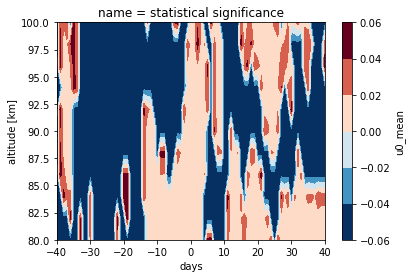

In [13]:
p_comp["u0_mean"].plot.contourf(x="days")